## Simulating any compartmental model using the `Spp` class

In the present notebook, we show how (most) compartmenal models can be simulated using the `pyross.stochastic.Spp` class. We allow users to specify any number of epidemiological classes, as well as any linear or infectious coupling between them.

In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)

### The SIR model

Below you will find the model-specification dictionary for the SIR model with some constant injection into the S class:

In [2]:
model_spec = {
    "classes" : ["S", "I"],

    "S" : {
        "constant"  : [ ["k"] ], 
        "infection" : [ ["I", "-beta", "overdispersion"] ]
    },

    "I" : {
        "linear"    : [ ["I", "-gamma"] ],
        "infection" : [ ["I", "beta", "overdispersion"] ]
    }
}



This corresponds to

$$
\begin{aligned}
\dot{S}_i & = - \beta \sum_\nu C_{ij} \frac{I_j}{N_j} S_i \\
\dot{I}_i & = \beta \sum_\nu C_{ij} \frac{I_j}{N_j} - \gamma I_i \\
\dot{R}_i & = \gamma I_i^\mu
\end{aligned}
$$

Let's go through each component of the model specification step-by-step:

-  The list `"classes" : ["S", "I", "R"]` defines the epidemiological
classes of the model. <i>The order in which they are written are important</i>, as this ordering will have to be mainained if giving the initial conditions of the simulation as an array. Each model requires the presence of a susceptible class. This class
will always be the first element of the list `classes`, regardless of whether it is labelled as `S` or not.
- The dynamics of each class is defined by a key-value pair. Consider

    <br>

    ```json
    "E" : {
        "linear"    : [ ["E", "-gammaE"] ],
        "infection" : [ ["I", "betaI"], ["A", "betaA"] ]
    },
    ```
    
    <br>
    
  - This reads out as:
      $$\dot{E}^\mu = -\gamma_E E + \beta_I \sum_\nu C^I_{\mu \nu} \frac{I^\nu}{N^\nu} S^\mu + \beta_A \sum_\nu C^A_{\mu \nu} \frac{A^\nu}{N^\nu} S^\mu.$$
  - The linear terms for each epidemic class is defined by the lists of lists:
  
    <br>
    
    ```json
    "linear"    : [ ["E", "-gammaE"] ]
    ```
    
    <br>
    
    Eeach pair in `linear` corresponds to the linear coupling 
    with the class and the coupling constant respectively. So
    `["E", "-gammaE"]` corresponds to the term $-\gamma_E E$ in
    the equation for $\dot{E}$. The minus sign in front of `gammaE`
    signifies that the negative of the coefficient should be used.
  - The infection terms are defined in a similar manner. Each pair
    in `infection` corresponds to the non-linear coupling with $S$
    and the coupling constant respectively. So `["I", "betaI"]`
    corresponds to the term $\beta_I \sum_\nu C^I_{\mu \nu} \frac{I^\nu}{N^\nu} S$.

Next, we define the parameter values:

In [3]:
parameters = {
    'beta' : 0.1,
    'gamma' : 0.1, 
    'k' : 1, 
    'overdispersion': 10,
    'overdispersion_mode': 1,
}

The initial conditions can be defined in either of two ways. They can either be defined using a dictionary, where for each model class we have a corresponding 1D array of length $M$ (where $M$ is the number of age-groups), or a numpy array. The numpy array must have dimensions $M \times (d-1)$, where $d$ is the number of model classes (so 3 for SIR, for example).

If the initial conditions are provided as a dictionary, we are free to leave out one of the classes. In which case the initial conditions of the left out class will be inferred from the others.

## Example 1: Small population

In [4]:
M = 3                
Ni = 1000*np.ones(M)
N = np.sum(Ni) 


# Initial conditions as an array
x0 = np.array([
    999, 1000, 1000, # S
    1,   0,    0,    # I
])

# Or initial conditions as a dictionary 
I0 = [10, 10, 10]
S0 = [n-20 for n in Ni]

x0 = {
    'S' : S0,
    'I' : I0 
}

CM = np.array([
    [1,   0.5, 0.1],
    [0.5, 1,   0.5],
    [0.1, 0.5, 1  ]
], dtype=float)

def contactMatrix(t):  
    return CM

# duration of simulation and data file
Tf = 160;  Nf=Tf+1; 

model = pyross.stochastic.Spp(model_spec, parameters, M, Ni)
# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

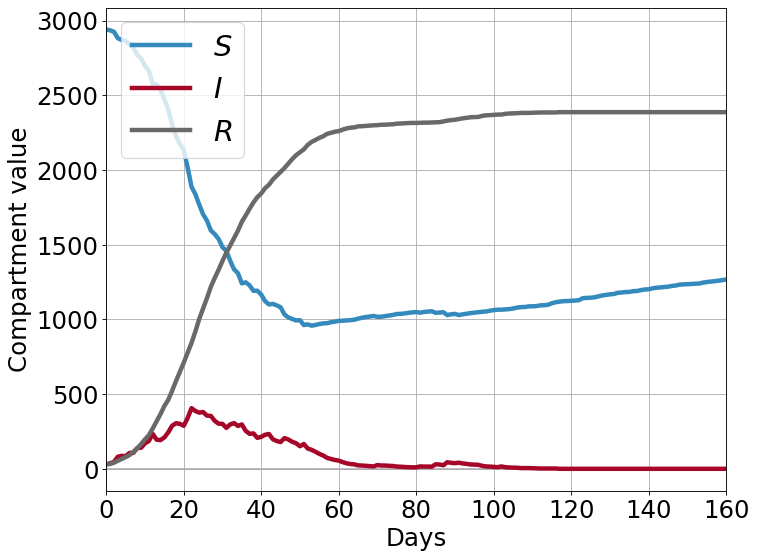

In [5]:
# plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, I/N, color='#A60628', alpha=0.3)
plt.plot(t, I, '-', color='#A60628', label='$I$', lw=4)

plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

In [6]:
Ns = 100

trajectories = np.zeros( [Ns,3,Nf] , 
                        dtype=float)

for i in range(Ns):
    print(i,end='\r')
    model = pyross.stochastic.Spp(model_spec, parameters, M, Ni)
    data = model.simulate(x0.copy(), contactMatrix, Tf, Nf)
    S = np.sum(model.model_class_data('S', data), axis=1)
    I = np.sum(model.model_class_data('I', data), axis=1)
    R = np.sum(model.model_class_data('R', data), axis=1)
    trajectories[i,0] = S.copy()
    trajectories[i,1] = I.copy()
    trajectories[i,2] = R.copy()
    #print(R)
    
mean_traj = np.mean(trajectories,axis=0)
std_traj = np.sqrt( np.var(trajectories,axis=0) )

In [7]:
parameters_2 = {
    'beta' : 0.1,
    'gamma' : 0.1, 
    'k' : 1, 
    'overdispersion': 10,
#    'overdispersion_mode': 0,
}


trajectories_2 = np.zeros( [Ns,M,Nf] , 
                        dtype=float)

for i in range(Ns):
    print(i,end='\r')
    model_2 = pyross.stochastic.Spp(model_spec, parameters_2, M, Ni)
    data = model_2.simulate(x0.copy(), contactMatrix, Tf, Nf)
    S = np.sum(model_2.model_class_data('S', data), axis=1)
    I = np.sum(model_2.model_class_data('I', data), axis=1)
    R = np.sum(model_2.model_class_data('R', data), axis=1)
    trajectories_2[i,0] = S.copy()
    trajectories_2[i,1] = I.copy()
    trajectories_2[i,2] = R.copy() 

mean_traj_2 = np.mean(trajectories_2,axis=0)
std_traj_2 = np.sqrt( np.var(trajectories_2,axis=0) )

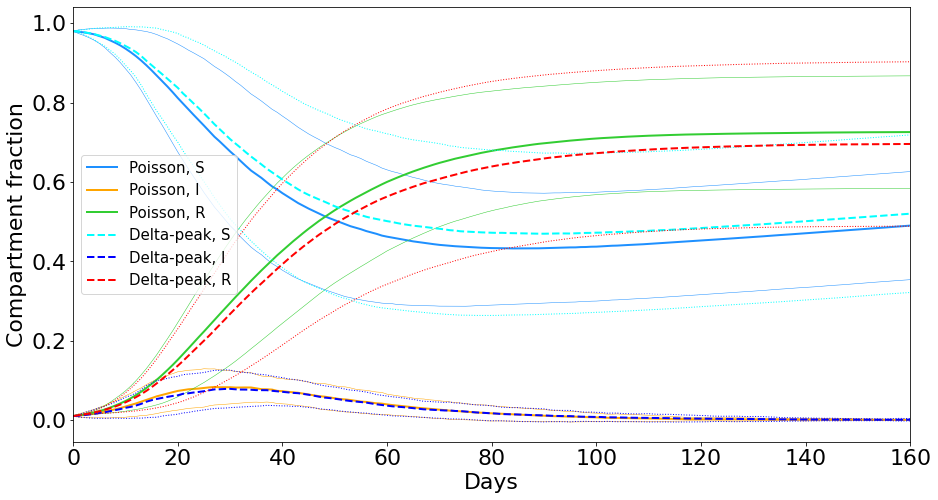

In [8]:
fig,ax = plt.subplots(1,1,figsize=(15,8))

colors=['dodgerblue','orange','limegreen']
colors_2=['cyan','blue','red']
labels=['S','I','R']

plot_var = True

for i,e in enumerate(mean_traj):
    if plot_var:
        ax.plot(t,(e - std_traj[i])/N,
                lw=0.5,
                color=colors[i])
        ax.plot(t,(e + std_traj[i])/N,
                lw=0.5,
                color=colors[i])
    ax.plot(t,e/N,
            lw=2,
            color=colors[i],
           label='Poisson, ' + str(labels[i]))
    
for i,e in enumerate(mean_traj_2):
    if plot_var:
        ax.plot(t,(e - std_traj_2[i])/N,
                lw=1,
                ls='dotted',
                color=colors_2[i])
        ax.plot(t,(e + std_traj_2[i])/N,
                lw=1,
                ls='dotted',
                color=colors_2[i])
    ax.plot(t,e/N,ls='--',
            lw=2,
            color=colors_2[i],
            label='Delta-peak, ' + str(labels[i]))
    
ax.set_xlim(np.min(t),np.max(t))
ax.set_xlabel(r'Days')
ax.set_ylabel(r'Compartment fraction')
ax.legend(fontsize=15)
plt.show()
plt.close(fig)

## Example 2: Large population and large overdispersion

In [9]:
M = 3                
Ni = 100000*np.ones(M)
N = np.sum(Ni) 


# Or initial conditions as a dictionary 
I0 = [2000, 2000, 2000]
S0 = [n-2000 for n in Ni]

x0 = {
    'S' : S0,
    'I' : I0 
}

CM = np.array([
    [1,   0.5, 0.1],
    [0.5, 1,   0.5],
    [0.1, 0.5, 1  ]
], dtype=float)


parameters = {
    'beta' : 0.1,
    'gamma' : 0.1, 
    'k' : 1, 
    'overdispersion': 300,
    'overdispersion_mode': 1,
}

def contactMatrix(t):  
    return CM

# duration of simulation and data file
Tf = 50;  Nf=Tf+1; 

model = pyross.stochastic.Spp(model_spec, parameters, M, Ni)
# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

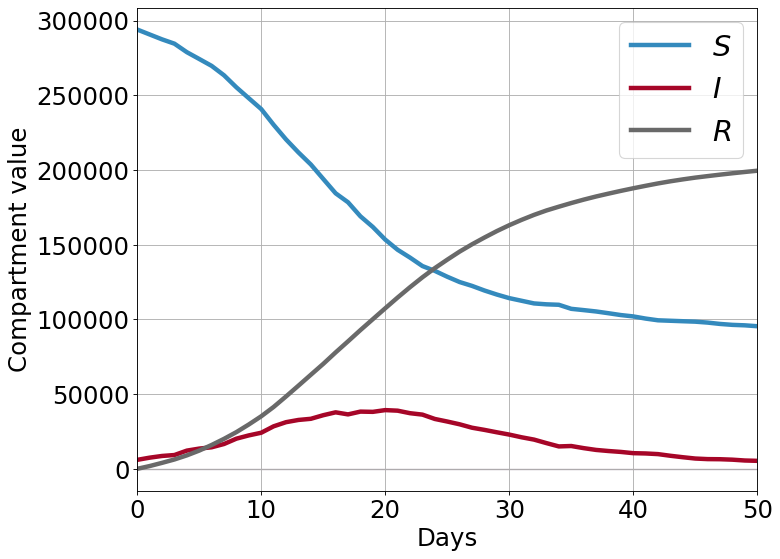

In [10]:
# plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, I/N, color='#A60628', alpha=0.3)
plt.plot(t, I, '-', color='#A60628', label='$I$', lw=4)

plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

In [11]:
Ns = 100

trajectories = np.zeros( [Ns,3,Nf] , 
                        dtype=float)

for i in range(Ns):
    print(i,end='\r')
    model = pyross.stochastic.Spp(model_spec, parameters, M, Ni)
    data = model.simulate(x0.copy(), contactMatrix, Tf, Nf)
    S = np.sum(model.model_class_data('S', data), axis=1)
    I = np.sum(model.model_class_data('I', data), axis=1)
    R = np.sum(model.model_class_data('R', data), axis=1)
    trajectories[i,0] = S.copy()
    trajectories[i,1] = I.copy()
    trajectories[i,2] = R.copy()
    
mean_traj = np.mean(trajectories,axis=0)
std_traj = np.sqrt( np.var(trajectories,axis=0) )

In [12]:
parameters_2 = {
    'beta' : 0.1,
    'gamma' : 0.1, 
    'k' : 1, 
    'overdispersion': 300,
    'overdispersion_mode': 0,
}


trajectories_2 = np.zeros( [Ns,M,Nf] , 
                        dtype=float)

for i in range(Ns):
    print(i,end='\r')
    model_2 = pyross.stochastic.Spp(model_spec, parameters_2, M, Ni)
    data = model_2.simulate(x0.copy(), contactMatrix, Tf, Nf)
    S = np.sum(model_2.model_class_data('S', data), axis=1)
    I = np.sum(model_2.model_class_data('I', data), axis=1)
    R = np.sum(model_2.model_class_data('R', data), axis=1)
    trajectories_2[i,0] = S.copy()
    trajectories_2[i,1] = I.copy()
    trajectories_2[i,2] = R.copy() 

mean_traj_2 = np.mean(trajectories_2,axis=0)
std_traj_2 = np.sqrt( np.var(trajectories_2,axis=0) )

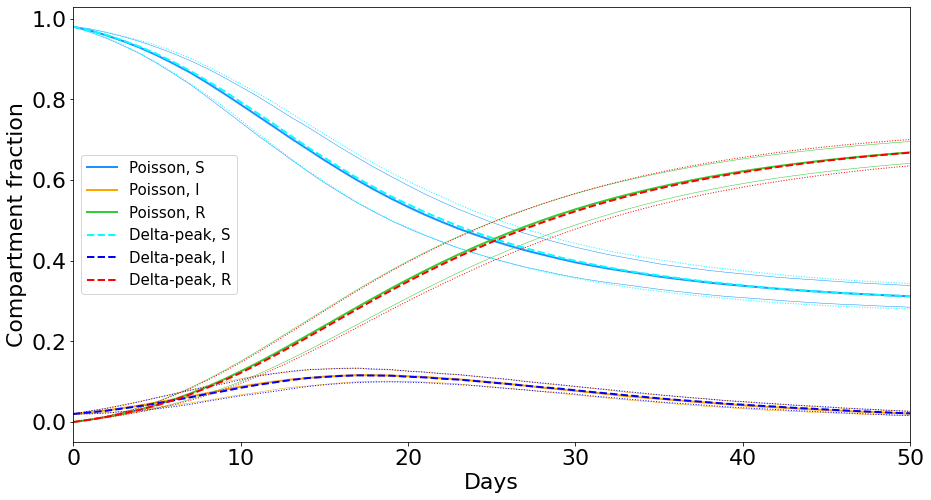

In [13]:
fig,ax = plt.subplots(1,1,figsize=(15,8))

colors=['dodgerblue','orange','limegreen']
colors_2=['cyan','blue','red']
labels=['S','I','R']

plot_var = True

for i,e in enumerate(mean_traj):
    if plot_var:
        ax.plot(t,(e - std_traj[i])/N,
                lw=0.5,
                color=colors[i])
        ax.plot(t,(e + std_traj[i])/N,
                lw=0.5,
                color=colors[i])
    ax.plot(t,e/N,
            lw=2,
            color=colors[i],
           label='Poisson, ' + str(labels[i]))
    
for i,e in enumerate(mean_traj_2):
    if plot_var:
        ax.plot(t,(e - std_traj_2[i])/N,
                lw=1,
                ls='dotted',
                color=colors_2[i])
        ax.plot(t,(e + std_traj_2[i])/N,
                lw=1,
                ls='dotted',
                color=colors_2[i])
    ax.plot(t,e/N,ls='--',
            lw=2,
            color=colors_2[i],
            label='Delta-peak, ' + str(labels[i]))
    
ax.set_xlim(np.min(t),np.max(t))
ax.set_xlabel(r'Days')
ax.set_ylabel(r'Compartment fraction')
ax.legend(fontsize=15)
plt.show()
plt.close(fig)